# Geothermal Datathon 2021
---

<img src="../figures/the_roaring_kitties_logo.png" width="200" align="center">

Team members:
- **Ricardo Lara**
- **Artur Davletshin**
- **Aigul Akberova**
- **Sercan Gul**
- **Hakki Aydin**
- **Jose Hernandez**


---

### Import Modules

In [12]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from xgboost.sklearn import  XGBRegressor

### Load Data

In [47]:
EB = pd.read_csv('merged data/Eaglebine_merged.csv')
DV = pd.read_csv('merged data/Duvernay_merged.csv')

EB = EB[EB.label == 'train']
DV = DV[DV.label == 'train']

## 1 Eaglebine
### Recursive Feature Elimination

In [6]:
EB.columns.to_list()

['UWI',
 'SurfLat',
 'SurfLong',
 'TD, m_x',
 'GL, m',
 'Depth subsea, m',
 'Depth subsurface, m',
 'TSC, h',
 'BHT, C',
 'Synthetic Temp, C',
 'Static Temp, C',
 'True Temp, C',
 'source',
 'label',
 'SurfaceLatitude_NAD27',
 'SurfaceLongitude_NAD27',
 'BottomLatitude_NAD27',
 'BottomLongitude_NAD27',
 'oil total cum, bbl',
 'gas total cum, mcf',
 'water total cum, bbl',
 'gor total average',
 'gas maximum, mcf',
 'oil maximum, bbl',
 'water maximum, bbl',
 'status',
 'Mud Wt',
 'TD, m_y',
 'MW at Depth(KB), m',
 'KB, m',
 'Min casing size, in',
 'cumoil',
 'cumgas',
 'cumwater',
 'GR',
 'NPHI_SS',
 'NPHI_LS',
 'DPHI_SS',
 'DPHI_LS',
 'PEFZ',
 'RHOB',
 'CAL']

In [51]:
features = [
 'TD, m_x',
 'GL, m',
 'Depth subsea, m',
 'Depth subsurface, m',
 'TSC, h',
 'BHT, C',
 'SurfaceLatitude_NAD27',
 'SurfaceLongitude_NAD27',
 'BottomLatitude_NAD27',
 'BottomLongitude_NAD27',
 'oil total cum, bbl',
 'gas total cum, mcf',
 'water total cum, bbl',
 'gor total average',
 'gas maximum, mcf',
 'oil maximum, bbl',
 'water maximum, bbl',
 'Mud Wt',
 'MW at Depth(KB), m',
 'Min casing size, in',
 'cumoil',
 'cumgas',
 'cumwater',
 'GR',
 'NPHI_SS',
 'NPHI_LS',
 'DPHI_SS',
 'DPHI_LS',
 'PEFZ',
 'RHOB',
 'CAL']

EB2 = EB[features]

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler,
                                   RobustScaler, PolynomialFeatures)
from sklearn.linear_model import LinearRegression

In [36]:
regressors = {}

In [37]:
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('bag', BaggingRegressor(base_estimator=LinearRegression(), 
                                n_estimators=100, n_jobs=-1, random_state=7)),
])

regressors['linear'] = BaggingRegressor(base_estimator=LinearRegression(), 
                                n_estimators=100, n_jobs=-1, random_state=7)

In [40]:
regressors['xgboost'] = XGBRegressor(objective='reg:squarederror', learning_rate=0.15, max_depth=10,
                n_estimators=200, colsample_bytree=0.85, alpha=10)



In [45]:
regressors['scaled_xgboost'] = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('xgboost', regressors['xgboost']),
    ])

In [52]:
selector = RFECV(regressors['scaled_xgboost'],step=1, cv=5, scoring='neg_mean_absolute_error')

selector = selector.fit(EB2.values, EB['True Temp, C'].values)

ValueError: when `importance_getter=='auto'`, the underlying estimator Pipeline should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

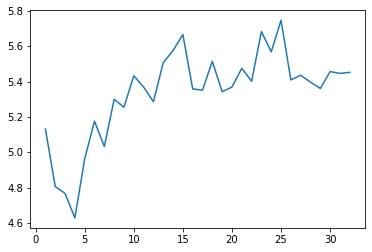

In [43]:
plt.plot(range(1, len(selector.grid_scores_)+1), -selector.grid_scores_)

In [44]:
EB2.loc[:, selector.support_]

,"TD, m_x","Depth subsea, m","Depth subsurface, m","MW at Depth(KB), m"
0,5982.919009,3725.417881,3830.848197,1342.339157
1,3284.219895,3168.700699,3289.828215,3284.219895
2,1880.006340,1747.418344,1887.748260,1882.139940
3,2498.750320,2379.268724,2504.358640,2498.750320
4,3352.799893,3203.289401,3358.408213,3352.799893
...,...,...,...,...
317,2108.911133,1975.469697,2108.728253,2103.119933
318,2231.135929,2095.804733,2236.744248,2231.135929
320,4923.129442,1296.619159,1530.217871,1524.609551
322,2191.816730,1929.246778,2185.233050,2179.624730


In [71]:
X = EB2.values
y = EB['True Temp, C'].values

In [73]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [81]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=4,
                          min_samples_split=5, n_estimators=500)

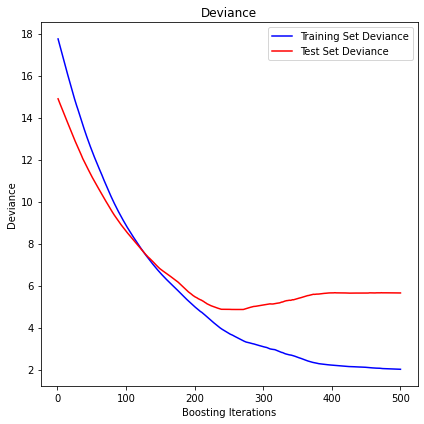

In [82]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Feature Importance (MDI)')

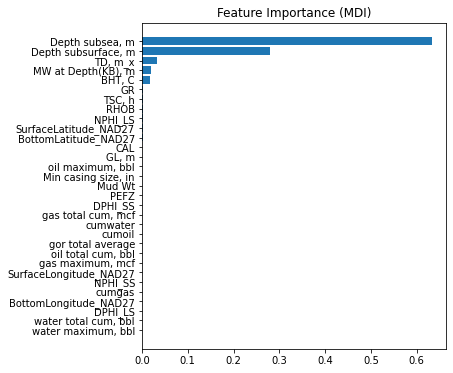

In [79]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Feature Importance (MDI)')

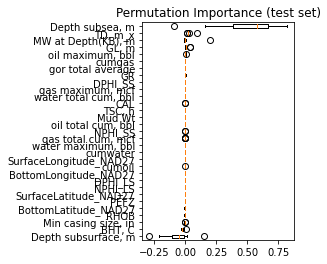

In [80]:
result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(features)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# 2 Duvernay

In [84]:
DV.columns.to_list()

['UWI',
 'Depth subsea, m',
 'BHT, C',
 'Formation',
 'Synthetic Temp, C',
 'Static Temp, C',
 'True Temp, C',
 'source',
 'label',
 'SurfaceLatitude_NAD27',
 'SurfaceLongitude_NAD27',
 'BottomLatitude_NAD27',
 'BottomLongitude_NAD27',
 'oil total cum, bbl',
 'gas total cum, mcf',
 'water total cum, bbl',
 'gor total average',
 'gas maximum, mcf',
 'oil maximum, bbl',
 'water maximum, bbl',
 'yield total average',
 'status',
 'DST BHT, C',
 'Maximum Shut-in Pressure, kPa',
 'GR',
 'NPHI_SS',
 'NPHI_LS',
 'DPHI_SS',
 'DPHI_LS',
 'PEFZ',
 'RHOB',
 'CAL']

In [85]:
dv_features = [
 'Depth subsea, m',
 'BHT, C',
 'SurfaceLatitude_NAD27',
 'SurfaceLongitude_NAD27',
 'BottomLatitude_NAD27',
 'BottomLongitude_NAD27',
 'oil total cum, bbl',
 'gas total cum, mcf',
 'water total cum, bbl',
 'gor total average',
 'gas maximum, mcf',
 'oil maximum, bbl',
 'water maximum, bbl',
 'yield total average',
 'DST BHT, C',
 'Maximum Shut-in Pressure, kPa',
 'GR',
 'NPHI_SS',
 'NPHI_LS',
 'DPHI_SS',
 'DPHI_LS',
 'PEFZ',
 'RHOB',
 'CAL']

DV2 = DV[dv_features]

In [87]:
dv_X = DV2.values
dv_y = DV['True Temp, C'].values

## 2.1 Recursive Feature Elimination

In [88]:
selector = RFECV(regressors['xgboost'],step=1, cv=5, scoring='neg_mean_absolute_error')

selector = selector.fit(dv_X, dv_y)

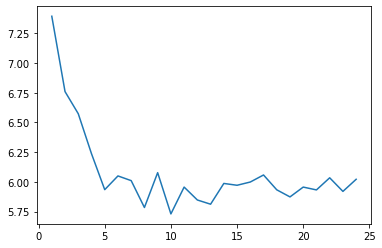

In [89]:
plt.plot(range(1, len(selector.grid_scores_)+1), -selector.grid_scores_)

In [90]:
DV2.loc[:, selector.support_]

,"Depth subsea, m","BHT, C",SurfaceLatitude_NAD27,SurfaceLongitude_NAD27,BottomLatitude_NAD27,"water total cum, bbl","oil maximum, bbl","water maximum, bbl","Maximum Shut-in Pressure, kPa",RHOB
0,716.00,48.33,55.027981,-116.903553,55.027981,654396.866419,11710.829580,8538.544249,12858.7,30.175647
1,1044.40,34.26,55.987511,-115.390554,55.987511,390.597000,1639.125000,351.600000,10782.0,2873.401100
3,171.90,29.00,54.167413,-113.002674,54.167402,641061.610721,11675.257464,8418.759124,5317.0,2614.128200
4,936.40,64.00,54.969037,-116.188158,54.969037,656268.759280,11715.843865,8555.394081,13781.0,2374.466300
5,1065.60,68.00,52.787328,-114.415621,52.787328,639914.504438,11672.334429,8408.686204,3778.0,2642.843500
...,...,...,...,...,...,...,...,...,...,...
502,252.50,38.60,52.877383,-112.097822,52.877383,643371.097787,11681.416096,8439.500955,6636.0,2715.381100
503,435.15,51.67,53.052422,-116.259189,53.052422,641289.479116,11675.902271,8420.868360,5205.5,-348.419603
504,249.20,35.30,52.879058,-111.876113,52.879058,643127.584946,11680.767486,8437.315210,6492.0,2691.669900
510,1341.20,68.80,53.072353,-115.285653,53.072353,1160.481000,210.709000,191.839000,6573.0,2743.601300


## 2.2 Permutation Importance

In [91]:

X_train, X_test, y_train, y_test = train_test_split(dv_X, dv_y, test_size=0.1, random_state=13)

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=4,
                          min_samples_split=5, n_estimators=500)

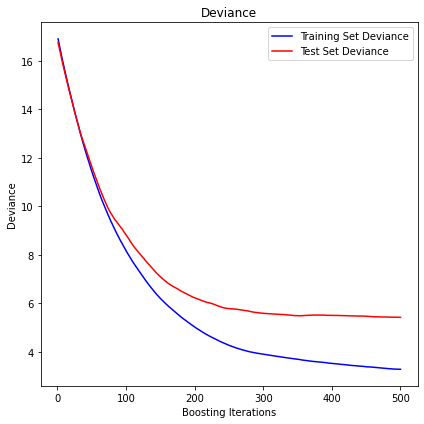

In [92]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Feature Importance (MDI)')

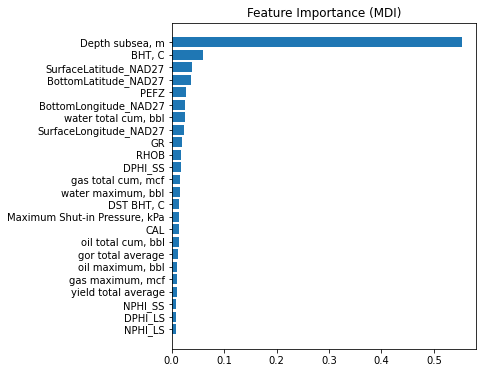

In [93]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(dv_features)[sorted_idx])
plt.title('Feature Importance (MDI)')

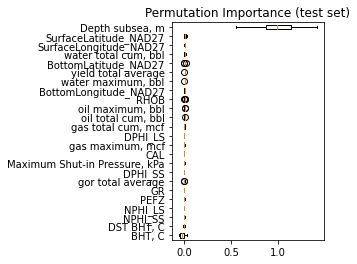

In [95]:
result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(dv_features)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()